In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.neighbors import NearestNeighbors

# Making sure TensorFlow can see the GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [3]:
# Load in your tracks, these are the downsampled version of the full grid. 
path = os.path.expanduser('~/ann-emulator-stellarages/data/yrec_eep.pqt')
ori_df = pd.read_parquet(path)
ori_df = ori_df.reset_index() 

# Get effective temperature out of log-space, and age into log-space
ori_df['teff'] = 10 ** ori_df['Log Teff(K)']
ori_df['age'] = np.log10(ori_df['Age(Gyr)']) 

# Apply log(g) and EEP cut to isolate RGB
rgb_df = ori_df[(ori_df['logg'] <= 3.5) & (ori_df['eep'] > 400)] 

# Now extract X and Y from the filtered DataFrame
X = rgb_df[['initial_mass', 'initial_met', 'logg']].copy()
Y = rgb_df[['age', 'teff']]

# Rename X columns for consistency
X.columns = ['mass', 'met', 'logg']


In [4]:
#Scale X & Y parameters, optimizers (like Adam) perform better when input features are on similar scales and to prevent any one parameter dominating
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.values)
Y_scaled = scaler_Y.fit_transform(Y.values)

# Split up data, the X_test and Y_test will be used later to see how our model is doing on unseen data
# This gives us training and validation, plus testing
X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=8)
# Final proportions: 64% train, 16% val, 20% test

##### This architecture follows [Saunders et al. (2024)](https://iopscience.iop.org/article/10.3847/1538-4357/ad1516).

In [8]:
def build_ann():
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))  # mass, met, logg
    for _ in range(6):
        model.add(layers.Dense(128, activation='elu')) #Activation: Exponential Linear Unit, captures noninearity better, also supports faster training
    model.add(layers.Dense(2))  # Outputs: age, teff
    return model

model = build_ann()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='mse')

#Save the best version
checkpoint_cb = ModelCheckpoint("best_ann_model.keras", save_best_only=True)

# Stop training if val_loss doesn't improve after 50 epochs
earlystop_cb = EarlyStopping(patience=50, restore_best_weights=True)

# Now train with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=2000,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6157 - val_loss: 0.0714
Epoch 2/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0540 - val_loss: 0.0473
Epoch 3/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - val_loss: 0.0441
Epoch 4/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0432 - val_loss: 0.0411
Epoch 5/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0430 - val_loss: 0.0385
Epoch 6/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408 - val_loss: 0.0362
Epoch 7/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341 - val_loss: 0.0342
Epoch 8/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0355 - val_loss: 0.0327
Epoch 9/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - val_loss: 0.0313
Epoch 10/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 11/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - val_loss: 0.0294
Epoch 12/2000
243/243 ━━━━━━━━

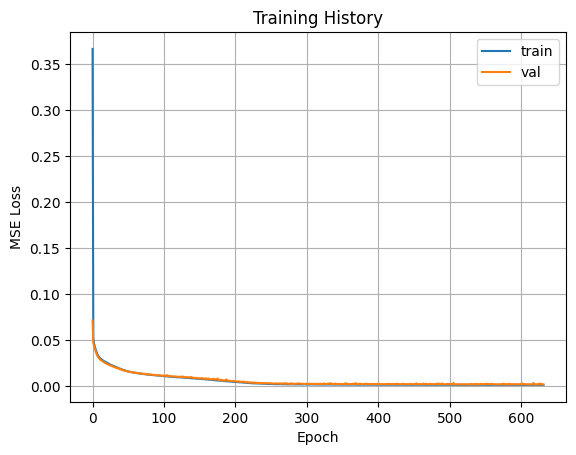

In [ ]:
# Plot training history -- How well our model learns over time
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.savefig('figures/traininghistory.png', dpi=300)
plt.show()

In [10]:
# Get final val loss
val_loss_std_units = history.history['val_loss'][-1]
val_rmse_std = np.sqrt(val_loss_std_units)

# Get std from scaler (for log(age) and Teff)
logage_std = np.sqrt(scaler_Y.var_[0])
teff_std = np.sqrt(scaler_Y.var_[1])

# Translate into physical units
logage_rmse = val_rmse_std * logage_std
teff_rmse = val_rmse_std * teff_std

print(f"RMSE in log(age): {logage_rmse:.4f} dex")
print(f"RMSE in Teff: {teff_rmse:.1f} K")

# Convert log(age) RMSE to % age error
age_factor = 10 ** logage_rmse
percent_error = (age_factor - 1) * 100
print(f"Age error factor: {age_factor:.3f}, (~{percent_error:.1f}% error)")


RMSE in log(age): 0.0230 dex
RMSE in Teff: 28.0 K
Age error factor: 1.054, (~5.4% error)


In [11]:
#Testing on the 20% we removed initially 
test_loss_std = model.evaluate(X_test, Y_test, verbose=0)
test_rmse_std = np.sqrt(test_loss_std)

logage_rmse_test = test_rmse_std * logage_std
teff_rmse_test = test_rmse_std * teff_std
age_factor_test = 10 ** logage_rmse_test

print(f"Test RMSE in log(age): {logage_rmse_test:.4f} dex")
print(f"Test RMSE in Teff: {teff_rmse_test:.1f} K")

age_factor = 10 ** logage_rmse_test
percent_error = (age_factor_test - 1) * 100
print(f"Age error factor: {age_factor_test:.3f}, (~{percent_error:.1f}% error)")

Test RMSE in log(age): 0.0208 dex
Test RMSE in Teff: 25.3 K
Age error factor: 1.049, (~4.9% error)


##### Now we will test this model on a set of stars from the [APOKASC3 catalog](https://ui.adsabs.harvard.edu/abs/2025ApJS..276...69P/abstract). These stars have ages linearly interpolated from the same YREC models used to train the data. We aim to evaluate how different the ANN model’s predicted values are from the original interpolated values.

In [13]:
# We need to apply the Salaris Correction (Salaris et al. 1993) to account for the heavy metal distribution in red giants
def salaris_corr(feh,afe):
    met = feh + np.log10(0.638*(10**afe) + 0.362)
    return met

In [14]:
colnames = ['KEPLER_ID','initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age','flag']
columns = [
    "KEPLER_ID", "DR16_TEFF_COR", "DR16_TEFF_COR_ERR", "DR17_TEFF_COR", "DR17_TEFF_COR_ERR",
    "APOKASC3_EVSTATE", "APOKASC3_SEIS_SOURCE", "APOKASC3_SPEC_SOURCE", "APOKASC3_MASS", "APOKASC3_MASS_ERR",
    "APOKASC3_RADIUS", "APOKASC3_RADIUS_ERR", "APOKASC3_LOGG", "APOKASC3_LOGG_ERR", "APOKASC3_TEFF", "APOKASC3_TEFF_ERR",
    "APOKASC3_LOGG_SPEC", "APOKASC3_LOGG_SPEC_ERR", "APOKASC3_M_H", "APOKASC3_M_H_ERR",
    "APOKASC3_ALPHA_M", "APOKASC3_ALPHA_M_ERR", "APOKASC3_CAT_AGE", "APOKASC3_AGE_RGB",
    "APOKASC3_AGE_RGB_PERR", "APOKASC3_AGE_RGB_MERR", "GAIA_TEFF", "GAIA_RADIUS", "GAIA_LUMINOSITY"
]

# YREC Linear interpolation results
yrecinterp_path = os.path.expanduser('~/ann-emulator-stellarages/data/yrec_linearinterp.csv')
df_subset = pd.read_csv(yrecinterp_path, header=None, names=colnames)

# Original APOKASC3 catalog data
apokasc3_path = os.path.expanduser('~/ann-emulator-stellarages/data/APOKASC3.csv')
df_subset2 = pd.read_csv(apokasc3_path, header=0, names=columns)

X_test = df_subset[['mass', 'met', 'logg']].copy()
X_test2 = df_subset2[['APOKASC3_MASS', 'APOKASC3_M_H', 'APOKASC3_LOGG']].copy()
X_test2['APOKASC3_M_H'] = salaris_corr(df_subset2['APOKASC3_M_H'], df_subset2['APOKASC3_ALPHA_M'])

# We are splittng up the stars that have converged in our linear interpolation method to use as validation of our ANN
X_test_clean = X_test[df_subset['flag'] == 0].copy() # Stars that converged using linear interpolation
X_full = X_test2.copy()

X_test_scaled = scaler_X.transform(X_test_clean) # Converged sample 
X_full_scaled = scaler_X.transform(X_full) # Full sample 

/home/l.morales/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/l.morales/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [15]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_Y.inverse_transform(predictions_scaled)

predictions_full_scaled = model.predict(X_full_scaled)
predictions_full = scaler_Y.inverse_transform(predictions_full_scaled)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [16]:
# Filling columns for the converged data 
df_clean = df_subset[df_subset['flag'] == 0].copy()
df_clean['log_age_pred'] = predictions[:, 0]
df_clean['teff_pred'] = predictions[:, 1]
df_clean['age_pred'] = 10 ** df_clean['log_age_pred']

# Filling columns for the full sample 
df_full= df_subset2.copy()
df_full['log_age_pred'] = predictions_full[:, 0]
df_full['teff_pred'] = predictions_full[:, 1]
df_full['age_pred'] = 10 ** df_full['log_age_pred']

In [19]:
# Calculating offset between the predicted age vs. the linearly interpolated age relative to linear interp age
df_clean['age_offset'] = df_clean['age_pred'] - df_clean['age']
df_clean['frac_offset'] = df_clean['age_offset'] / df_clean['age']

# Calculating offset between the predicted teff vs. the linearly interpolated teff relative to linear interp teff
df_clean['teff_offset'] = df_clean['teff_pred'] - df_clean['teff']
df_clean['frac_offset_teff'] = df_clean['teff_offset'] / df_clean['teff']

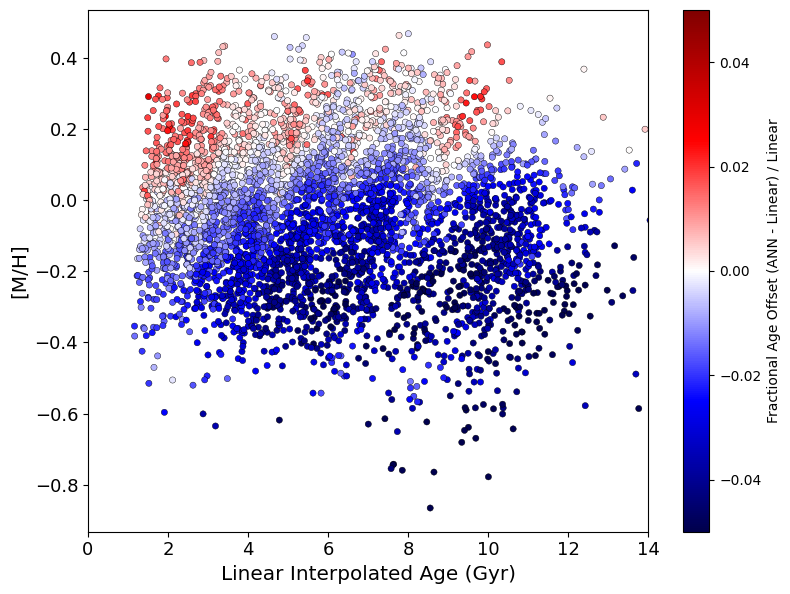

In [ ]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['age'], df_clean['met'], 
                 c=df_clean['frac_offset'], cmap='seismic', s=20, edgecolor='k', linewidth=0.3,vmin=-0.05,vmax=0.05)

plt.colorbar(sc, label='Fractional Age Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Age (Gyr)',size='x-large')
plt.ylabel('[M/H]',size='x-large')
plt.xlim(0,14)
plt.tight_layout()
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('figures/resultsANN.png')
plt.show()

In [21]:
mean_offset = df_clean['frac_offset'].mean()
std_offset = df_clean['frac_offset'].std()
print(f"Mean fractional offset: {mean_offset:.4f} ± {std_offset:.4f}")

Mean fractional offset: -0.0169 ± 0.0175


### Interpreting the Negative Age Offset

This is a promising result! The linear interpolation used in the traditional method tends to bias ages toward the lower-mass track, which corresponds to older ages, due to how interpolation weights are assigned. The fact that the ANN is predicting slightly younger ages suggests that it’s more accurately mapping out the non-linear relationship between stellar parameters and age. In other words, it's correcting for the traditional method's tendency to overestimate age in certain regions of the grid.



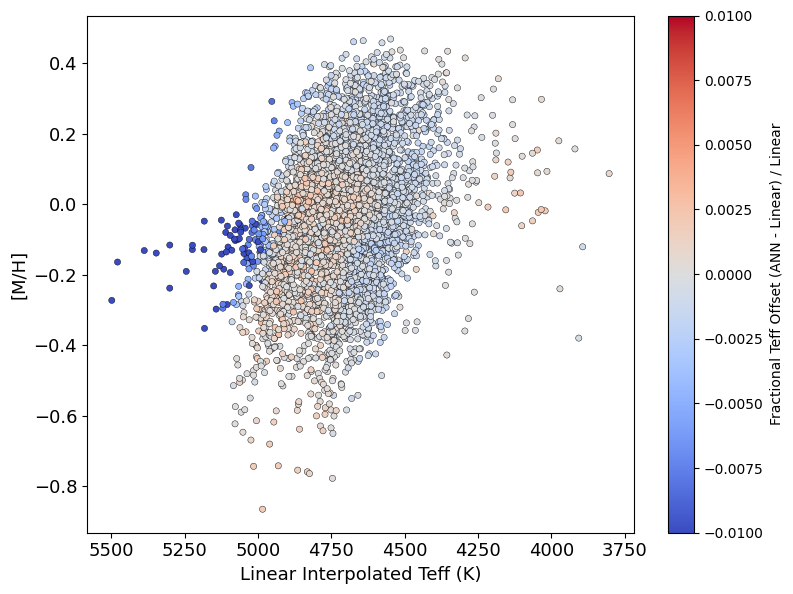

In [ ]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['teff'], df_clean['met'], 
                 c=df_clean['frac_offset_teff'], cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3,
                 vmin=-0.01, vmax=0.01)  # You can adjust these limits if needed

plt.colorbar(sc, label='Fractional Teff Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Teff (K)',size=13)
plt.ylabel('[M/H]',size=13)
# plt.xlim(0,14)
plt.tight_layout()
plt.gca().invert_xaxis()
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('figures/resultsANN_teff.png')
plt.show()

In [26]:
mean_offset_teff = df_clean['frac_offset_teff'].mean()
std_offset_teff = df_clean['frac_offset_teff'].std()
print(f"Mean fractional Teff offset: {mean_offset_teff:.4f} ± {std_offset_teff:.4f}")

Mean fractional Teff offset: -0.0005 ± 0.0029


### Interpreting the Temperature Offset

This is also a good indication! A small offset here is expected since temperature tends to have a more linear relationship with the input stellar parameters. It suggests that the ANN is capturing the expected trends.

#### Lets try another validation method using Z-score with K Nearest Neighbors. We want to access the local variation to check if anything seems off. 

In [27]:
# Parameter space used for comparison (same used in training)
X = X_test2[['APOKASC3_MASS', 'APOKASC3_M_H', 'APOKASC3_LOGG']].values
y_pred = df_full['age_pred'].values

# Setup KNN
k = 5  # Keeping K low to avoid mixing stars from different evolutionay paths. The RGB is narrow!
nn = NearestNeighbors(n_neighbors=k+1) 
nn.fit(X)

# Get neighbors for each star
distances, indices = nn.kneighbors(X)
neighbor_preds = np.array([y_pred[idxs[1:]] for idxs in indices])

# Compute mean and std of neighbor predictions
neighbor_mean = neighbor_preds.mean(axis=1)
neighbor_std = neighbor_preds.std(axis=1)

# Quantify how different each point is from its neighbors
z_score_like = (y_pred - neighbor_mean) / neighbor_std

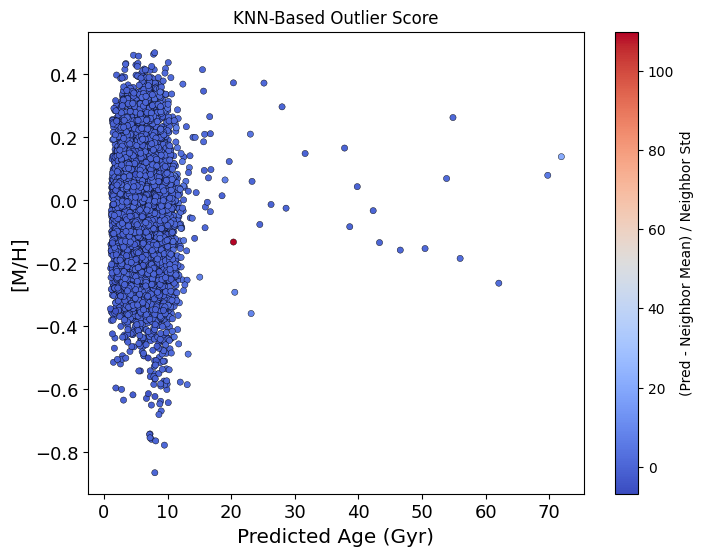

In [28]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_full['age_pred'], X_test2['APOKASC3_M_H'],
                 c=z_score_like, cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3)
plt.colorbar(sc, label='(Pred - Neighbor Mean) / Neighbor Std')
plt.xlabel('Predicted Age (Gyr)',size='x-large')
plt.ylabel('[M/H]',size='x-large')
plt.title('KNN-Based Outlier Score')
plt.gca().tick_params(axis='both',labelsize=13)

# plt.xlim(0,14)
plt.show()


There is one data point that has a high score, but this is outside of the relevant ages (i.e. 0-14 gyrs) and so we will ignore that. :) We can assume that the majority of stars that are estimated to be older than the universe are the products of binary interactions or mass-transfer events. 

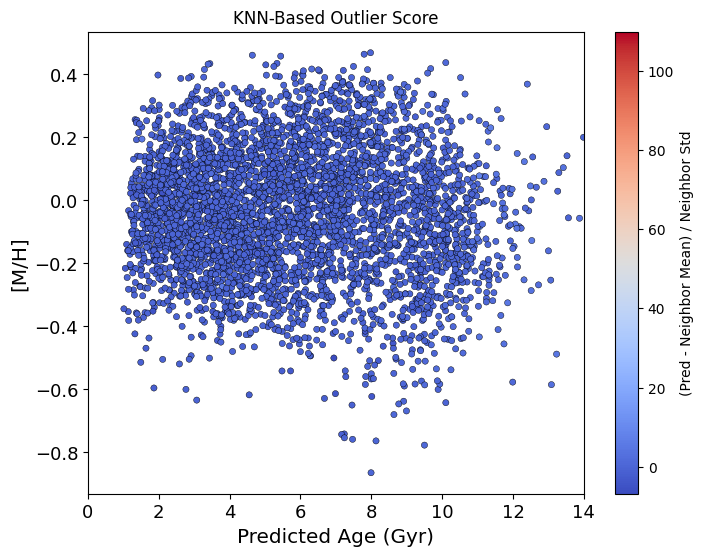

In [29]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_full['age_pred'], X_test2['APOKASC3_M_H'],
                 c=z_score_like, cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3)
plt.colorbar(sc, label='(Pred - Neighbor Mean) / Neighbor Std')
plt.xlabel('Predicted Age (Gyr)',size='x-large')
plt.ylabel('[M/H]',size='x-large')
plt.title('KNN-Based Outlier Score')
plt.gca().tick_params(axis='both',labelsize=13)

plt.xlim(0,14)
plt.show()

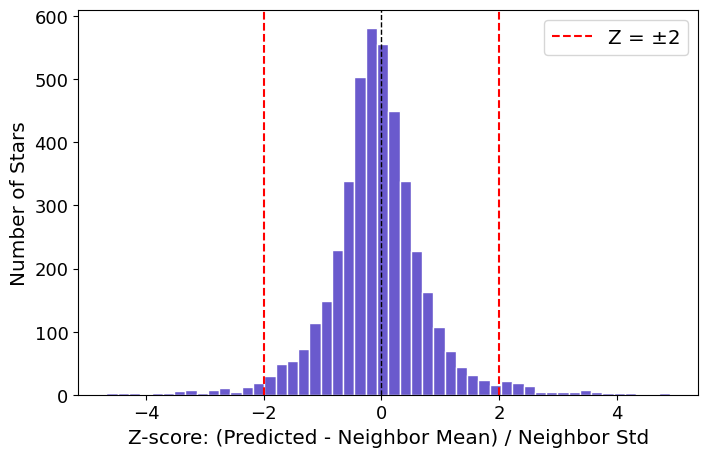

In [30]:
plt.figure(figsize=(8,5))
plt.hist(z_score_like[np.abs(z_score_like) < 5], bins=50, color='slateblue', edgecolor='white')
plt.axvline(0, color='k', linestyle='--', lw=1)
plt.axvline(2, color='r', linestyle='--', label='Z = ±2')
plt.axvline(-2, color='r', linestyle='--')
plt.xlabel('Z-score: (Predicted - Neighbor Mean) / Neighbor Std',size='x-large')
plt.ylabel('Number of Stars',size='x-large')
plt.legend(fontsize='x-large')
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('figures/score.png')
plt.show()


Z-scores look great! We want them centered around 0 following a normal distribution, showing that our model isn't deviating from local expectations. 

In [31]:
# Below we assess whether stars near the edge of the parameter space 
# (mass, metallicity, logg) tend to have higher prediction deviations
# by comparing their z-scores 
MASS_IDX = 0
MET_IDX = 1
LOGG_IDX = 2

mass_min, mass_max = X[:, MASS_IDX].min(), X[:, MASS_IDX].max()
met_min, met_max   = X[:, MET_IDX].min(), X[:, MET_IDX].max()
logg_min, logg_max = X[:, LOGG_IDX].min(), X[:, LOGG_IDX].max()

delta = 0.02 #Small scaling due to narrow structure of the RGB

is_edge = (
    (np.abs(X[:, MASS_IDX] - mass_min) < delta) |
    (np.abs(X[:, MASS_IDX] - mass_max) < delta) |
    (np.abs(X[:, MET_IDX] - met_min) < delta) |
    (np.abs(X[:, MET_IDX] - met_max) < delta) |
    (np.abs(X[:, LOGG_IDX] - logg_min) < delta) |
    (np.abs(X[:, LOGG_IDX] - logg_max) < delta)
)

In [32]:
edge_scores = np.abs(z_score_like[is_edge])
interior_scores = np.abs(z_score_like[~is_edge])

print(f"Edge stars: {len(edge_scores)}")
print(f"Interior stars: {len(interior_scores)}")

print("Mean z-score (edge):", edge_scores.mean())
print("Mean z-score (interior):", interior_scores.mean())


Edge stars: 50
Interior stars: 4289
Mean z-score (edge): 0.96435493
Mean z-score (interior): 0.6480149


The average z-score for stars at the edge of the grid is 0.97, while interior stars have a mean of 0.65. Both values fall below 1, indicating that predictions remain within $1\sigma$ of their local neighborhood across the entire parameter space.